<a href="https://colab.research.google.com/github/chiwacych/greenhouse-ml/blob/main/Copy_of_greenhouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Setup and Configuration

In [ ]:
# ## 1. Setup and Configuration
import os
import torch
import time
import json
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, DistributedSampler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import json
from google.colab import drive

# Initialize TPU (v2-8)
os.environ['XLA_USE_BF16'] = '1'  # Critical for v2-8 memory
device = xm.xla_device()
xm.master_print(f"Initialized TPU v2-8 with {xm.xrt_world_size()} cores")

Initialized TPU v2-8 with 1 cores


### Mount Google Drive

In [ ]:
#drive.flush_and_unmount()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Dataset_aug'
log_path = '/content/drive/MyDrive/Dataset_aug/models/log'


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Dataset_aug

Bean  Cashew  Maize  Potato  Tomato


In [ ]:
!ls "/content/drive/MyDrive/Dataset_aug/Bean"
!ls "/content/drive/MyDrive/models"
!ls "/content/drive/MyDrive/Dataset_aug/models/log"


test_set  train_set
Bean_all_model.pth   Cashew_all_model.pth  Potato_leaf_model.pth	    Tomato_all_model.pth
Bean_leaf_model.pth  log		   Potato_tuber_model.pth	    tomato_model_final.pt
Bean_pod_model.pth   Maize_all_model.pth   Tomato_all_converted_model.onnx
ls: cannot access '/content/drive/MyDrive/Dataset_aug/models/log': No such file or directory


### 2. Dataset Configuration

In [ ]:
# ## 3. Dataset Configuration (TPU v2-8 Optimized)
CROP_CONFIG = {
    'Tomato': {'path': 'Tomato', 'parts': ['default'], 'batch_size': 128},
    'Potato': {'path': 'Potato', 'parts': ['leaf', 'tuber'], 'batch_size': 96},  # tuber needs smaller batches
    'Maize': {'path': 'Maize', 'parts': ['default'], 'batch_size': 128},
    'Bean': {'path': 'Bean', 'parts': ['leaf', 'pod'], 'batch_size': 96},  # pod images are larger
    'Cashew': {'path': 'Cashew', 'parts': ['default'], 'batch_size': 128}
}

# TPU v2-8 Notes:
# - Max batch size per core: ~128 for 224px images
# - tuber/pod crops need smaller batches (96)

### 3. Enhanced Data Pipeline

In [ ]:
# ## 3. Dataset Class
class TPUv2Dataset:
    def __init__(self, root_path, crop_type, plant_part=None, img_size=224, batch_size=96):
        """Optimized for TPU v2-8's 16GB RAM per core"""
        self.root = os.path.join(root_path, crop_type)
        if plant_part:
            self.root = os.path.join(self.root, plant_part)

        self.train_path = os.path.join(self.root, 'train_set')
        self.test_path = os.path.join(self.root, 'test_set')

        # Simplified transforms for v2-8
        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(img_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # Reduced batch sizes for v2-8
        self.batch_size = batch_size * xm.xrt_world_size()

    def get_loaders(self):
        train_set = datasets.ImageFolder(self.train_path, transform=self.train_transform)
        test_set = datasets.ImageFolder(self.test_path, transform=self.train_transform)

        # TPU distributed sampler
        train_sampler = DistributedSampler(
            train_set,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=True
        )

        # Fewer workers for v2-8 (4 instead of 8)
        train_loader = DataLoader(
            train_set,
            batch_size=self.batch_size,
            sampler=train_sampler,
            num_workers=4,
            pin_memory=True,
            drop_last=True
        )

        test_loader = DataLoader(
            test_set,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )

        return (
            pl.MpDeviceLoader(train_loader, device),
            pl.MpDeviceLoader(test_loader, device),
            train_set.classes
        )

## 4. Model Factory

In [ ]:
# ## 4. Model Factory
def create_tpu_model(num_classes):
    """EfficientNet-b0 fits better in v2-8 memory"""
    model = models.efficientnet_b0(pretrained=True)

    # Modify classifier
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

    # XLA optimizations
    model = model.to(device)
    if xm.xrt_world_size() > 1:
        model = torch_xla.core.xla_model.XlaDataParallel(model)

    return model

## 5. Training Engine

In [ ]:
# ## 5. Training Engine
class TPUv2Trainer:
    def __init__(self, model, train_loader, test_loader, classes):
        self.model = model
        self.loaders = (train_loader, test_loader)
        self.classes = classes

        # Lower initial LR for v2-8 stability
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=3e-5 * xm.xrt_world_size(),  # Scaled learning rate
            weight_decay=0.01
        )

        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer,
            step_size=5,
            gamma=0.1
        )

        self.criterion = torch.nn.CrossEntropyLoss()

    def train_epoch(self, epoch):
        self.model.train()
        train_loader, _ = self.loaders
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            # Move inputs and labels to the TPU device
            inputs = inputs.to(device)
            labels = labels.to(device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)

            loss.backward()
            xm.optimizer_step(self.optimizer)

            running_loss += loss.item()

        self.scheduler.step()
        return running_loss / len(train_loader)

    def train(self, epochs=15):  # Fewer epochs for v2-8
        for epoch in range(epochs):
            loss = self.train_epoch(epoch)
            xm.master_print(f'[Epoch {epoch+1}] Loss: {loss:.4f}')
            if xm.is_master_ordinal() and (epoch+1) % 5 == 0:
                self._save_checkpoint(epoch)

    def _save_checkpoint(self, epoch):
        # Local saving path
        checkpoint_path = f'checkpoint_epoch_{epoch}.pth'

        # Google Drive saving path
        drive_path = "/content/drive/MyDrive/model_checkpoints"
        os.makedirs(drive_path, exist_ok=True)
        drive_checkpoint_path = os.path.join(drive_path, f'checkpoint_epoch_{epoch}.pth')

        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model': self.model.to('cpu'),  # Convert model to CPU for portability
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'classes': self.classes
        }

        torch.save(checkpoint, checkpoint_path)
        torch.save(checkpoint, drive_checkpoint_path)  # Save to Google Drive

        print(f"Checkpoint saved locally: {checkpoint_path}")
        print(f"Checkpoint saved to Google Drive: {drive_checkpoint_path}")

## 6. Evaluation and Visualization

In [ ]:
# ## 6. Evaluation
def evaluate_tpu(model, test_loader, classes):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    from sklearn.metrics import classification_report
    print(classification_report(all_labels, all_preds, target_names=classes))

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    plt.show()

## 7. Main Training Pipeline

In [ ]:
# ## 7. Main Training Pipeline
def train_crop_tpu(crop_type, plant_part=None):
    model_dir = "/content/drive/MyDrive/models_mod"
    os.makedirs(model_dir, exist_ok=True)
    model_path = f"{model_dir}/{crop_type}_{plant_part or 'all'}_model.pth"

    # Skip training if model already exists
    if os.path.exists(model_path):
        xm.master_print(f"Model {model_path} already exists. Skipping training.")
        return

    # Get crop-specific batch size
    batch_size = CROP_CONFIG[crop_type]['batch_size']

    # Initialize dataset
    dataset = TPUv2Dataset(base_path, crop_type=crop_type, plant_part=plant_part, batch_size=batch_size)
    train_loader, test_loader, classes = dataset.get_loaders()

    # Train
    model = create_tpu_model(len(classes))
    trainer = TPUv2Trainer(model, train_loader, test_loader, classes)
    trainer.train()

    # Evaluate
    if xm.is_master_ordinal():
        evaluate_tpu(model, test_loader, classes)

    # Save the model (PyTorch)
    if xm.is_master_ordinal():
        torch.save({
            'model_state_dict': model.state_dict(),
            'classes': classes,
            'crop_type': crop_type,
            'plant_part': plant_part
        }, model_path)
        xm.master_print(f"Saved PyTorch model to {model_path}")

    # Extract input shape dynamically
    if xm.is_master_ordinal():
        sample_batch, _ = next(iter(train_loader))
        _, channels, height, width = sample_batch.shape
        dummy_input = torch.randn(1, channels, height, width)

        # Export ONNX model
        onnx_path = f"{model_dir}/{crop_type}_{plant_part or 'all'}_model.onnx"
        torch.onnx.export(model, dummy_input, onnx_path, opset_version=11)
        xm.master_print(f"Saved ONNX model to {onnx_path}")

    # Log training details
    if xm.is_master_ordinal():
        training_details = {
            "crop_type": crop_type,
            "plant_part": plant_part,
            "model_path": model_path,
            "onnx_path": onnx_path
        }

        with open(log_path, "w") as log_file:
            json.dump(training_details, log_file, indent=4)

        xm.master_print(f"Saved training details to {log_path}")

In [ ]:

# ## 9. Execute Training
# ### Option 1: Test single crop (recommended first)

train_crop_tpu('Tomato')  # Lightest crop for testing

# ### Option 2: Train all crops (uncomment when ready)
#train_all_crops()


# **TPU v2-8 Specific Tips**:
# 1. For OOM errors: Reduce batch size in CROP_CONFIG
# 2. Monitor memory: `!gcloud alpha compute tpus tpu-vm ssh your-tpu --zone=us-central1-a --command="free -h"`
# 3. tuber/pod crops may need img_size=192

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1:   0%|          | 0/169 [00:00<?, ?it/s]

[Epoch 1] Loss: nan


Epoch 2:   0%|          | 0/169 [00:00<?, ?it/s]

[Epoch 2] Loss: nan


Epoch 3:   0%|          | 0/169 [00:00<?, ?it/s]

[Epoch 3] Loss: nan


Epoch 4:   0%|          | 0/169 [00:00<?, ?it/s]

[Epoch 4] Loss: nan


Epoch 5:   0%|          | 0/169 [00:00<?, ?it/s]

[Epoch 5] Loss: nan
Checkpoint saved locally: checkpoint_epoch_4.pth
Checkpoint saved to Google Drive: /content/drive/MyDrive/model_checkpoints/checkpoint_epoch_4.pth


Epoch 6:   0%|          | 0/169 [00:00<?, ?it/s]

RuntimeError: torch_xla/csrc/aten_xla_bridge.cpp:110 : Check failed: xtensor 
*** Begin stack trace ***
	tsl::CurrentStackTrace()
	torch_xla::bridge::GetXlaTensor(at::Tensor const&)
	torch_xla::XLANativeFunctions::convolution_overrideable(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long)
	
	
	c10::Dispatcher::callBoxed(c10::OperatorHandle const&, std::vector<c10::IValue, std::allocator<c10::IValue> >*) const
	
	
	at::_ops::convolution_overrideable::call(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, bool, c10::ArrayRef<c10::SymInt>, c10::SymInt)
	at::native::_convolution(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long, bool, bool, bool, bool)
	
	
	at::functionalization::functionalize_op_helper(c10::OperatorHandle const&, std::vector<c10::IValue, std::allocator<c10::IValue> >*)
	at::functionalization::_functionalize_aten_op<at::_ops::_convolution, false, at::Tensor (at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, bool, c10::ArrayRef<c10::SymInt>, c10::SymInt, bool, bool, bool, bool)>::call(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long, bool, bool, bool, bool)
	torch_xla::XLANativeFunctions::_convolution(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long, bool, bool, bool, bool)
	
	
	at::_ops::_convolution::call(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, bool, c10::ArrayRef<c10::SymInt>, c10::SymInt, bool, bool, bool, bool)
	at::native::convolution(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long)
	
	
	c10::Dispatcher::callBoxed(c10::OperatorHandle const&, std::vector<c10::IValue, std::allocator<c10::IValue> >*) const
	
	
	at::_ops::convolution::redispatch(c10::DispatchKeySet, at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, bool, c10::ArrayRef<c10::SymInt>, c10::SymInt)
	
	
	at::_ops::convolution::call(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, bool, c10::ArrayRef<c10::SymInt>, c10::SymInt)
	
	at::native::conv2d_symint(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::SymInt)
	
	
	at::_ops::conv2d::call(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::SymInt)
	
	
	_PyObject_MakeTpCall
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyObject_FastCallDictTstate
	_PyObject_Call_Prepend
	
	_PyObject_MakeTpCall
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyObject_FastCallDictTstate
	_PyObject_Call_Prepend
	
	_PyObject_MakeTpCall
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyObject_FastCallDictTstate
	_PyObject_Call_Prepend
	
	_PyObject_MakeTpCall
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyObject_FastCallDictTstate
	_PyObject_Call_Prepend
	
	_PyObject_MakeTpCall
	_PyEval_EvalFrameDefault
	
	PyEval_EvalCode
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	
	_PyEval_EvalFrameDefault
	
	
	PyObject_Call
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	
	
	
	
	
	_PyEval_EvalFrameDefault
	
	PyEval_EvalCode
	
	
	PyObject_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	
	Py_RunMain
	Py_BytesMain
	
	__libc_start_main
	_start
*** End stack trace ***
Input tensor is not an XLA tensor: torch.FloatTensor


Training Tomato

Training Tomato (all)
Model /content/drive/MyDrive/models/Tomato_all_model.pth already exists. Skipping training.

Training Potato

Training Potato (leaf)
Model /content/drive/MyDrive/models/Potato_leaf_model.pth already exists. Skipping training.

Training Potato (tuber)
Model /content/drive/MyDrive/models/Potato_tuber_model.pth already exists. Skipping training.

Training Maize

Training Maize (all)
Model /content/drive/MyDrive/models/Maize_all_model.pth already exists. Skipping training.

Training Bean

Training Bean (leaf)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 146MB/s] 


Epoch 1:   0%|          | 0/57 [00:00<?, ?it/s]

[Epoch 1] Loss: 2.0495


Epoch 2:   0%|          | 0/57 [00:00<?, ?it/s]

[Epoch 2] Loss: 1.9083


Epoch 3:   0%|          | 0/57 [00:00<?, ?it/s]

[Epoch 3] Loss: 1.7947


Epoch 4:   0%|          | 0/57 [00:00<?, ?it/s]

[Epoch 4] Loss: 1.6887


Epoch 5:   0%|          | 0/57 [00:00<?, ?it/s]

[Epoch 5] Loss: 1.5858


Epoch 6:   0%|          | 0/57 [00:00<?, ?it/s]

[Epoch 6] Loss: 1.5382


Epoch 7:   0%|          | 0/57 [00:00<?, ?it/s]

[Epoch 7] Loss: 1.5355


Epoch 8:   0%|          | 0/57 [00:00<?, ?it/s]

[Epoch 8] Loss: 1.5351


Epoch 9:   0%|          | 0/57 [00:00<?, ?it/s]

[Epoch 9] Loss: 1.5378


Epoch 10:   0%|          | 0/57 [00:00<?, ?it/s]

[Epoch 10] Loss: 1.5404


Epoch 11:   0%|          | 0/57 [00:00<?, ?it/s]

[Epoch 11] Loss: 1.5355


Epoch 12:   0%|          | 0/57 [00:00<?, ?it/s]

[Epoch 12] Loss: 1.5397


Epoch 13:   0%|          | 0/57 [00:00<?, ?it/s]

[Epoch 13] Loss: 1.5362


Epoch 14:   0%|          | 0/57 [00:00<?, ?it/s]

[Epoch 14] Loss: 1.5363


Epoch 15:   0%|          | 0/57 [00:00<?, ?it/s]

[Epoch 15] Loss: 1.5329


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

                      precision    recall  f1-score   support

   angular leaf spot       0.40      0.07      0.12        29
         anthracnose       0.83      0.99      0.90       120
cercospora leaf spot       0.33      0.12      0.17        17
     fungi pathogens       0.12      0.04      0.06        27
         halo blight       0.33      0.12      0.18        25
             healthy       0.70      0.88      0.78       238
potassium deficiency       0.00      0.00      0.00         8
                rust       0.95      0.83      0.89       120

            accuracy                           0.75       584
           macro avg       0.46      0.38      0.39       584
        weighted avg       0.70      0.75      0.71       584



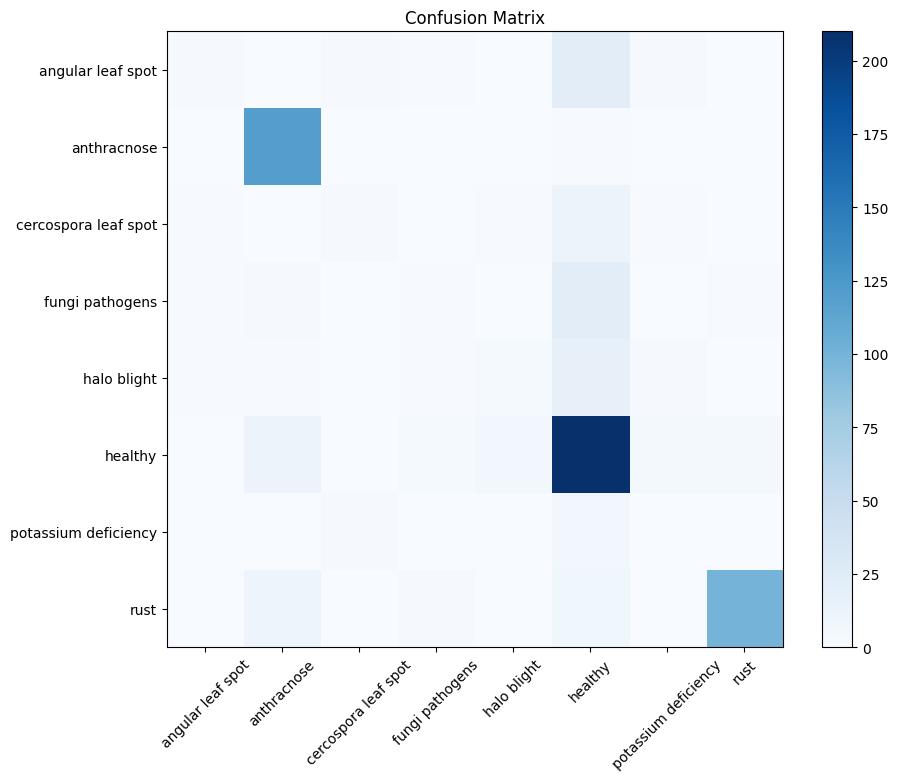


Training Bean (pod)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1:   0%|          | 0/7 [00:00<?, ?it/s]

[Epoch 1] Loss: 0.6780


Epoch 2:   0%|          | 0/7 [00:00<?, ?it/s]

[Epoch 2] Loss: 0.6635


Epoch 3:   0%|          | 0/7 [00:00<?, ?it/s]

[Epoch 3] Loss: 0.6429


Epoch 4:   0%|          | 0/7 [00:00<?, ?it/s]

[Epoch 4] Loss: 0.6244


Epoch 5:   0%|          | 0/7 [00:00<?, ?it/s]

[Epoch 5] Loss: 0.6144


Epoch 6:   0%|          | 0/7 [00:00<?, ?it/s]

[Epoch 6] Loss: 0.6010


Epoch 7:   0%|          | 0/7 [00:00<?, ?it/s]

[Epoch 7] Loss: 0.6032


Epoch 8:   0%|          | 0/7 [00:00<?, ?it/s]

[Epoch 8] Loss: 0.6044


Epoch 9:   0%|          | 0/7 [00:00<?, ?it/s]

[Epoch 9] Loss: 0.6021


Epoch 10:   0%|          | 0/7 [00:00<?, ?it/s]

[Epoch 10] Loss: 0.6094


Epoch 11:   0%|          | 0/7 [00:00<?, ?it/s]

[Epoch 11] Loss: 0.6021


Epoch 12:   0%|          | 0/7 [00:00<?, ?it/s]

[Epoch 12] Loss: 0.6083


Epoch 13:   0%|          | 0/7 [00:00<?, ?it/s]

[Epoch 13] Loss: 0.6105


Epoch 14:   0%|          | 0/7 [00:00<?, ?it/s]

[Epoch 14] Loss: 0.6038


Epoch 15:   0%|          | 0/7 [00:00<?, ?it/s]

[Epoch 15] Loss: 0.6044


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

                    precision    recall  f1-score   support

bacterial pathogen       0.69      0.80      0.74        41
           healthy       0.77      0.64      0.70        42

          accuracy                           0.72        83
         macro avg       0.73      0.72      0.72        83
      weighted avg       0.73      0.72      0.72        83



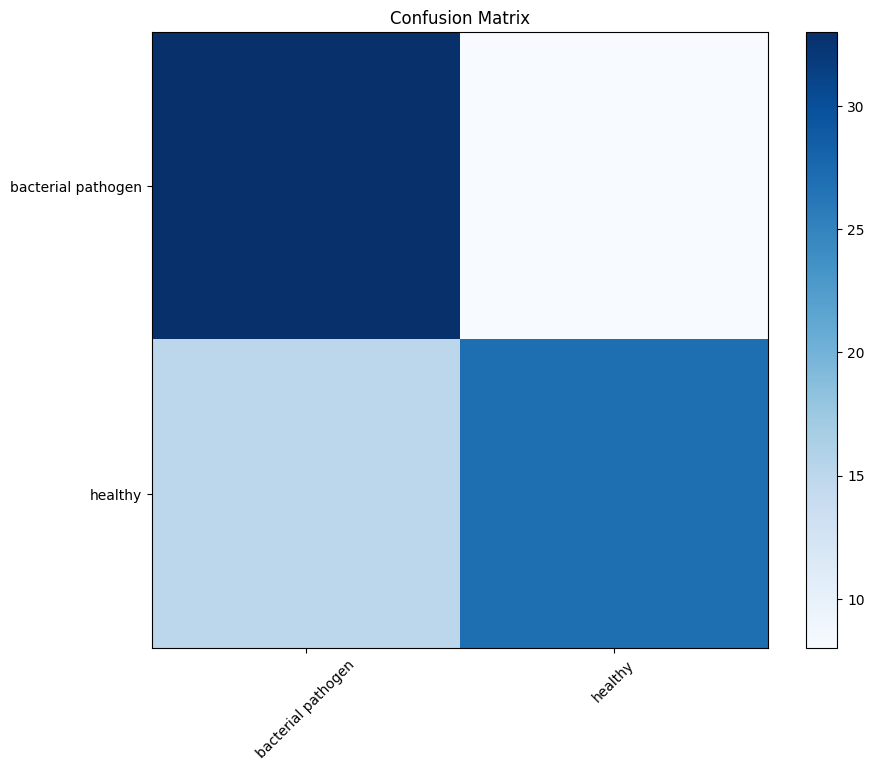


Training Cashew

Training Cashew (all)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 1] Loss: nan


Epoch 2:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 2] Loss: nan


Epoch 3:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 3] Loss: nan


Epoch 4:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 4] Loss: nan


Epoch 5:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 5] Loss: nan


Epoch 6:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 6] Loss: nan


Epoch 7:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 7] Loss: nan


Epoch 8:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 8] Loss: nan


Epoch 9:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 9] Loss: nan


Epoch 10:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 10] Loss: nan


Epoch 11:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 11] Loss: nan


Epoch 12:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 12] Loss: nan


Epoch 13:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 13] Loss: nan


Epoch 14:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 14] Loss: nan


Epoch 15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 15] Loss: nan


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

              precision    recall  f1-score   support

 anthracnose       0.27      1.00      0.42      1838
     gumosis       0.00      0.00      0.00       425
     healthy       0.00      0.00      0.00      1336
  leaf miner       0.00      0.00      0.00      1487
    red rust       0.00      0.00      0.00      1815

    accuracy                           0.27      6901
   macro avg       0.05      0.20      0.08      6901
weighted avg       0.07      0.27      0.11      6901



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


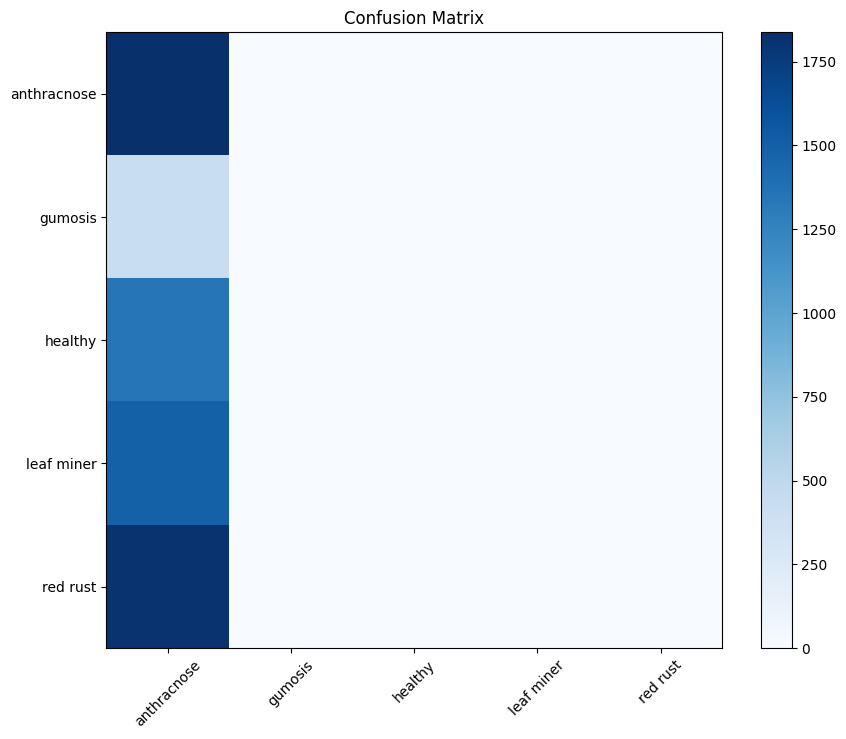

{'Tomato': {'default': {'status': 'success'}},
 'Potato': {'leaf': {'status': 'success'}, 'tuber': {'status': 'success'}},
 'Maize': {'default': {'status': 'success'}},
 'Bean': {'leaf': {'status': 'success'}, 'pod': {'status': 'success'}},
 'Cashew': {'default': {'status': 'success'}}}

In [ ]:
#train_all_crops()

### Convert model from .pth to .onxx for easy portability

In [ ]:
!pip install onnx
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.5 MB/s eta 0:00:00


In [ ]:
import torch
import onnx
import onnxruntime as ort
from torchvision import transforms, models  # Import models
import numpy as np
import os # Import the os module

def convert_pth_to_onnx(pth_path, onnx_path, input_shape=(1, 3, 224, 224)):
    """
    Convert .pth model to universal ONNX format
    Args:
        pth_path: Path to .pth file
        onnx_path: Output ONNX file path
        input_shape: Model's expected input shape (batch, channels, height, width)
    """
    # Load model (map to CPU for export)
    device = torch.device('cpu')

    # 1. Load the state dictionary and create a new model instance:
    state_dict = torch.load(pth_path, map_location=device)

    # Assuming you're using efficientnet_b0, change this if needed
    model = models.efficientnet_b0(pretrained=False)
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(state_dict['classes']))

    model.load_state_dict(state_dict['model_state_dict'])
    model.eval()

    # Create dummy input with correct shape
    dummy_input = torch.randn(*input_shape)

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(onnx_path), exist_ok=True)

    # Export with platform-agnostic settings
    torch.onnx.export(
        model,
        dummy_input,
        onnx_path,
        export_params=True,
        opset_version=14,  # Widely supported version
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        },
        training=torch.onnx.TrainingMode.EVAL,
        operator_export_type=torch.onnx.OperatorExportTypes.ONNX
    )

    # Verify ONNX model
    onnx_model = onnx.load(onnx_path)
    onnx.checker.check_model(onnx_model)

    print(f"Successfully converted to ONNX: {onnx_path}")
    print(f"Input shape: {input_shape}")
    print(f"Output shape: {onnx_model.graph.output[0].type.tensor_type.shape}")


def verify_onnx(onnx_path, test_input=None):
    """Verify ONNX model works across available providers"""
    if test_input is None:
        test_input = np.random.randn(1, 3, 224, 224).astype(np.float32)

    print("\nTesting ONNX model with available providers:")
    for provider in ort.get_available_providers():
        try:
            sess = ort.InferenceSession(onnx_path, providers=[provider])
            outputs = sess.run(None, {'input': test_input})
            print(f"✅ {provider}: Success! Output shape: {outputs[0].shape}")
        except Exception as e:
            print(f"❌ {provider}: Failed - {str(e)}")

# Example usage
if __name__ == "__main__":
    convert_pth_to_onnx(
        pth_path="/content/drive/MyDrive/models/Tomato_all_model.pth",
        onnx_path="/content/drive/MyDrive/models/Tomato_all_converted_model.onnx", # Changed to a file path
        input_shape=(1, 3, 224, 224)  # Adjust to your model's input size
    )
    verify_onnx("/content/drive/MyDrive/models/Tomato_all_converted_model.onnx") # Changed to a file path

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Successfully converted to ONNX: /content/drive/MyDrive/models/Tomato_all_converted_model.onnx
Input shape: (1, 3, 224, 224)
Output shape: dim {
  dim_param: "batch_size"
}
dim {
  dim_value: 5
}


Testing ONNX model with available providers:
✅ AzureExecutionProvider: Success! Output shape: (1, 5)
✅ CPUExecutionProvider: Success! Output shape: (1, 5)
